In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Setup for plotting
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

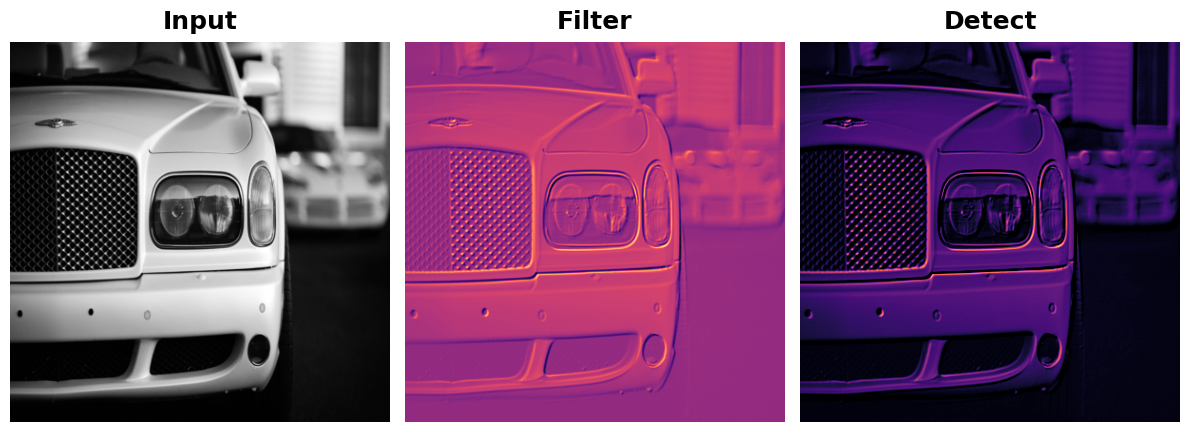

In [2]:
# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize((400, 400), Image.BILINEAR)
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return image

# Load image
image_path = '../input/computer-vision-resources/car_illus.jpg'
image = load_and_preprocess_image(image_path)

# Embossing kernel
kernel = torch.tensor([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2],
], dtype=torch.float32).reshape(1, 1, 3, 3)

# Apply convolution
image_filter = nn.functional.conv2d(
    input=image,
    weight=kernel,
    stride=1,
    padding='valid',
)

# Apply ReLU activation
image_detect = nn.functional.relu(image_filter)

# Show the results
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(image_filter.squeeze().detach().numpy())
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(image_detect.squeeze().detach().numpy())
plt.axis('off')
plt.title('Detect')
plt.show();

# Feature Extraction with Convolution

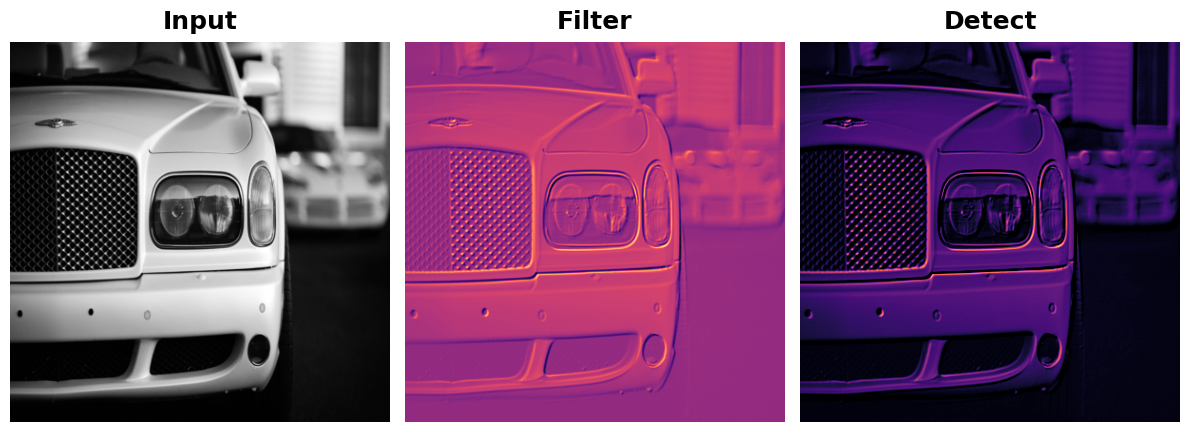

In [3]:
# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize((400, 400), Image.BILINEAR)
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return image

# Load image
image_path = '../input/computer-vision-resources/car_illus.jpg'
image = load_and_preprocess_image(image_path)

# Embossing kernel
kernel = torch.tensor([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2],
], dtype=torch.float32).reshape(1, 1, 3, 3)

# Apply convolution
image_filter = nn.functional.conv2d(
    input=image,
    weight=kernel,
    stride=1,
    padding='valid',
)

# Apply ReLU activation
image_detect = nn.functional.relu(image_filter)

# Show the results
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(image_filter.squeeze().detach().numpy())
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(image_detect.squeeze().detach().numpy())
plt.axis('off')
plt.title('Detect')
plt.show();

# Apply Pooling to Condense

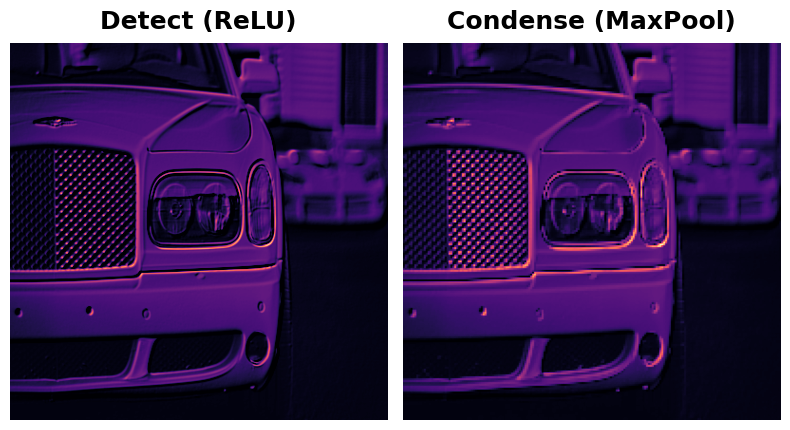

In [5]:
# Apply maximum pooling with a (2, 2) window and stride 2
import torch.nn as nn

# Apply maximum pooling with a (2, 2) window and stride 2
# The input 'image_detect' has shape (batch_size, channels, height, width)
image_condense = nn.MaxPool2d(
    kernel_size=(2, 2),
    stride=(2, 2),
    padding=(0, 0), # Or 'same' for newer versions of PyTorch
)(image_detect)

# Show what pooling did to the feature
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(image_detect.squeeze().detach().numpy())
plt.axis('off')
plt.title("Detect (ReLU)")
plt.subplot(122)
plt.imshow(image_condense.squeeze().detach().numpy())
plt.axis('off')
plt.title("Condense (MaxPool)")
plt.show();

# Explore Invariance

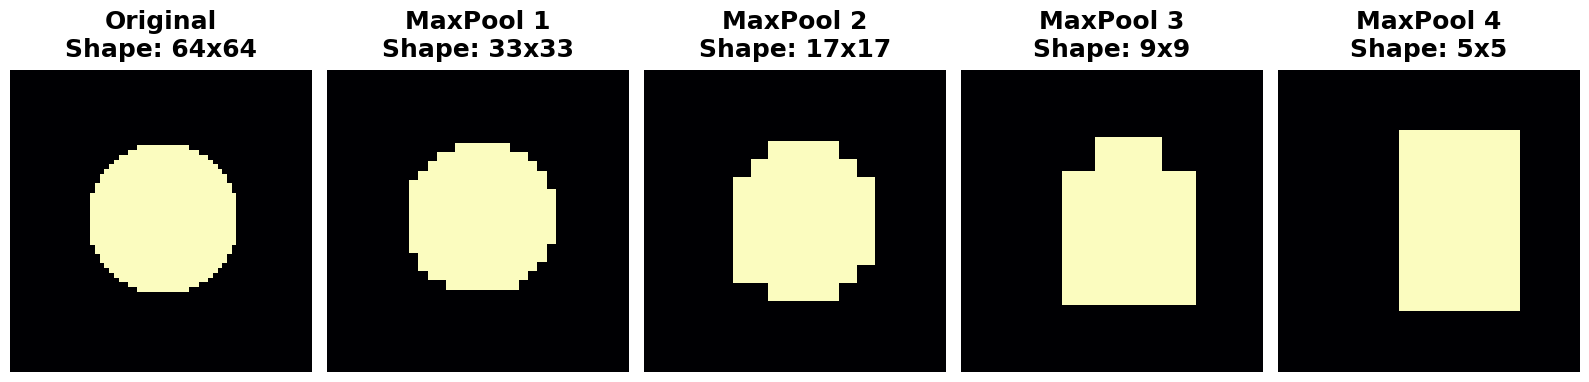

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Function to create a circle image and apply random shift
def create_and_transform_circle(size, r_shrink=4, jitter=3):
    image = torch.zeros(size)
    center = (size[0] // 2, size[1] // 2)
    radius = min(size) // r_shrink
    
    # Create the circle
    for i in range(size[0]):
        for j in range(size[1]):
            if (i - center[0])**2 + (j - center[1])**2 < radius**2:
                image[i, j] = 1.0

    # Apply random shift
    dx = np.random.randint(-jitter, jitter + 1)
    dy = np.random.randint(-jitter, jitter + 1)
    shifted_image = torch.roll(image, shifts=(dx, dy), dims=(0, 1))
    
    return shifted_image.unsqueeze(0).unsqueeze(0)

# 2) Explore Invariance
# This section demonstrates translation invariance by repeatedly applying max pooling.
REPEATS = 4
SIZE = [64, 64]

# Create a randomly shifted circle
image = create_and_transform_circle(SIZE)
image = image.squeeze()

plt.figure(figsize=(16, 4))
plt.subplot(1, REPEATS + 1, 1)
plt.imshow(image.numpy(), vmin=0, vmax=1)
plt.title("Original\nShape: {}x{}".format(image.shape[0], image.shape[1]))
plt.axis('off')

# Now condense with maximum pooling several times
maxpool_layer = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1)

for i in range(REPEATS):
    ax = plt.subplot(1, REPEATS + 1, i + 2)
    image = image.unsqueeze(0).unsqueeze(0)
    image = maxpool_layer(image)
    image = image.squeeze()
    
    # The image size will reduce, but the shape in the title should reflect the new size.
    plt.imshow(image.numpy(), vmin=0, vmax=1)
    plt.title("MaxPool {}\nShape: {}x{}".format(i + 1, image.shape[0], image.shape[1]))
    plt.axis('off')

plt.show();

# Global Average Pooling

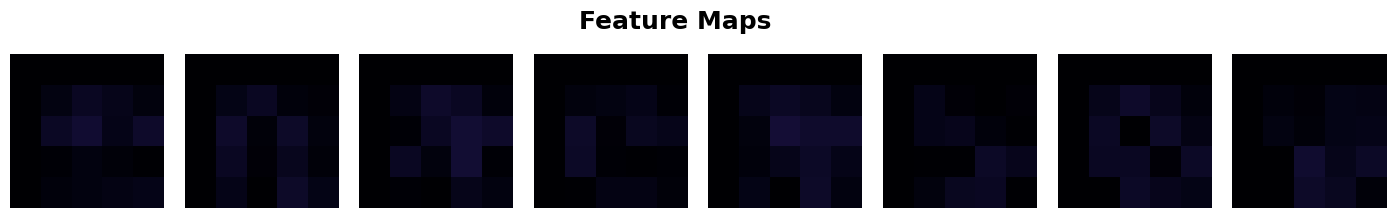

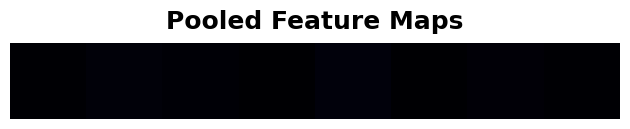

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# Function to create a random map with decay for visualization
def random_map(size, scale=0.1, decay_power=4):
    map_ = np.random.rand(size[0], size[1]) * scale
    center = np.array(size) / 2
    for i in range(size[0]):
        for j in range(size[1]):
            dist = np.linalg.norm(np.array([i, j]) - center)
            decay = 1 - (dist / (max(size)/2))**decay_power
            map_[i, j] *= decay
    return map_

# Global Average Pooling section
feature_maps = [random_map([5, 5]) for _ in range(8)]

# Plotting the initial feature maps
gs = gridspec.GridSpec(1, 8, wspace=0.01, hspace=0.01)
plt.figure(figsize=(18, 2))
for i, feature_map in enumerate(feature_maps):
    plt.subplot(gs[i])
    plt.imshow(feature_map, vmin=0, vmax=1)
    plt.axis('off')
plt.suptitle('Feature Maps', size=18, weight='bold', y=1.1)
plt.show()

# Reformat for PyTorch
feature_maps_tensor = [torch.tensor(fm, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                       for fm in feature_maps]

# Use a Global Average Pooling layer
global_avg_pool = nn.AdaptiveAvgPool2d(1)
pooled_maps = [global_avg_pool(feature_map) for feature_map in feature_maps_tensor]

# Stack the list of tensors into a single tensor
pooled_tensor = torch.stack(pooled_maps).squeeze()

# Reshape the 1D tensor to a 2D array for plotting
img = pooled_tensor.detach().numpy().reshape(1, -1) 

# Display the pooled values
plt.imshow(img, vmin=0, vmax=1)
plt.axis('off')
plt.title('Pooled Feature Maps')
plt.show()

In [ ]:
# To run this section, you need to have the VGG16 model and dataset.
# Since we can't directly load the Keras/TF model, we'll use PyTorch's VGG16.
# You'll also need to structure your dataset correctly.

# Define the model with a pretrained VGG16 base
from torchvision import models

# Load the pretrained VGG16 model
pretrained_base = models.vgg16(weights='VGG16_Weights.DEFAULT')
# Replace the classifier with a global average pooling layer
class VGG16_Pooled(nn.Module):
    def __init__(self, pretrained_base):
        super(VGG16_Pooled, self).__init__()
        self.features = pretrained_base.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        # The output shape will be (batch_size, 512, 1, 1)
        # We want to flatten it to (batch_size, 512)
        return x.view(x.size(0), -1)

model = VGG16_Pooled(pretrained_base)

# Load dataset (you need to have this directory structure)
# The below code assumes a specific file structure, adjust as needed.
data_transform = transforms.Compose([
    transforms.Resize((224, 224)), # VGG16 expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_path = '../input/car-or-truck/train'
try:
    ds = datasets.ImageFolder(root=dataset_path, transform=data_transform)
    ds_iter = iter(DataLoader(ds, batch_size=1, shuffle=True))

    # Run an image through the model and visualize the features
    image_tensor, label = next(ds_iter)
    
    # Get pooled features
    with torch.no_grad():
        car_features = model(image_tensor)

    # Reshape for visualization
    car_features = car_features.reshape(16, 32).numpy()
    label = label.item()

    # Get original image for display
    original_image = Image.open(ds.imgs[ds.samples.index((ds.imgs[0][0], label))][0]).convert('RGB')
    
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(["Car", "Truck"][label])
    
    plt.subplot(122)
    plt.imshow(car_features)
    plt.title('Pooled Feature Maps')
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Error loading dataset: {e}. Please ensure the directory structure is correct.")
    print("Expected structure: {dataset_path}/car/image.jpg and {dataset_path}/truck/image.jpg")